### Import Library

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import timm
import copy
from torch.optim import lr_scheduler

### Device Selection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

In [4]:
# Data transforms with more augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# Load data
train_dir = "/content/drive/MyDrive/Premium Subscription/Projects/Research and Innovation/data/training"
val_dir = "/content/drive/MyDrive/Premium Subscription/Projects/Research and Innovation/data/validation"

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = train_data.classes
model_results = {}
all_trained_models = [] # List to store all trained models for ensembling


### Model Setup

In [5]:
def get_model(name, num_classes):
    if name == "resnet18":
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = torchvision.models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "mobilenet_v2":
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "shufflenet_v2":
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "squeezenet":
        model = torchvision.models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes
    else:
        raise ValueError(f"Model '{name}' not supported.")
    return model.to(device)

### Training Function

In [6]:
def train_model(model, epochs=5, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=patience-1)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / len(train_data)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        model.eval()
        v_loss, v_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                v_loss += loss.item()
                v_correct += (outputs.argmax(1) == labels).sum().item()

        epoch_val_loss = v_loss / len(val_loader)
        epoch_val_acc = v_correct / len(val_data)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.2f}, Val Acc={epoch_val_acc:.2f}, LR={optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs. Validation accuracy did not improve for {patience} epochs.")
                break

    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc

### Accuracy and Loss Graph

In [7]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

### Confusion Matrix and Report

In [8]:
def evaluate_model(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

### Roc Curve

In [9]:
def plot_roc(model):
    y_score, y_true = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            y_score.extend(outputs.cpu())
            y_true.extend(labels)
    y_true = label_binarize(y_true, classes=list(range(len(class_names))))
    y_score = torch.stack(y_score).numpy()
    plt.figure()
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


### Ensemble Voting Implementation

In [10]:
def ensemble_predict_proba(models, data_loader, device):
    """
    Predicts probabilities for a dataset using an ensemble of models (soft voting).
    """
    for model in models:
        model.eval() # Set all models to evaluation mode

    all_predictions = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            batch_predictions = []
            for model in models:
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1) # Get probabilities
                batch_predictions.append(probabilities.cpu().numpy())

            # Average probabilities across models for the current batch
            avg_predictions = np.mean(batch_predictions, axis=0)
            all_predictions.append(avg_predictions)

    return np.vstack(all_predictions)

def ensemble_evaluate(models, data_loader, class_names, device):
    """
    Evaluates an ensemble of models and generates classification report and confusion matrix.
    """
    y_true = []
    for _, labels in data_loader:
        y_true.extend(labels.cpu().numpy())

    # Get averaged probabilities from ensemble
    ensemble_probs = ensemble_predict_proba(models, data_loader, device)

    # Get predicted classes from averaged probabilities
    ensemble_preds = np.argmax(ensemble_probs, axis=1)

    print("\n--- Ensemble Model Performance ---")
    print(classification_report(y_true, ensemble_preds, target_names=class_names))

    cm = confusion_matrix(y_true, ensemble_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Ensemble Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Calculate ensemble accuracy for storage
    ensemble_accuracy = np.mean(ensemble_preds == y_true)
    return ensemble_accuracy, ensemble_probs, y_true

### Training and Storing Models

In [11]:
all_trained_models = [] # List to store trained models for ensembling

### Restnet 18


--- Training ResNet18 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Epoch 1: Train Acc=0.69, Val Acc=0.78, LR=0.000100
Epoch 2: Train Acc=0.81, Val Acc=0.83, LR=0.000100
Epoch 3: Train Acc=0.82, Val Acc=0.81, LR=0.000100
Epoch 4: Train Acc=0.85, Val Acc=0.81, LR=0.000100
Epoch 5: Train Acc=0.88, Val Acc=0.83, LR=0.000100
Epoch 6: Train Acc=0.89, Val Acc=0.84, LR=0.000100
Epoch 7: Train Acc=0.91, Val Acc=0.82, LR=0.000100
Epoch 8: Train Acc=0.92, Val Acc=0.85, LR=0.000100
Epoch 9: Train Acc=0.92, Val Acc=0.84, LR=0.000100
Epoch 10: Train Acc=0.93, Val Acc=0.86, LR=0.000100
Epoch 11: Train Acc=0.94, Val Acc=0.83, LR=0.000100
Epoch 12: Train Acc=0.95, Val Acc=0.85, LR=0.000100
Epoch 13: Train Acc=0.95, Val Acc=0.86, LR=0.000100
Epoch 14: Train Acc=0.93, Val Acc=0.85, LR=0.000100
Epoch 15: Train Acc=0.94, Val Acc=0.84, LR=0.000100
Early stopping triggered after 15 epochs. Validation accuracy did not improve for 5 epochs.
              precision    recall  f1-score   support

         abn       0.85      0.93      0.89       247
         bmt       0.74     

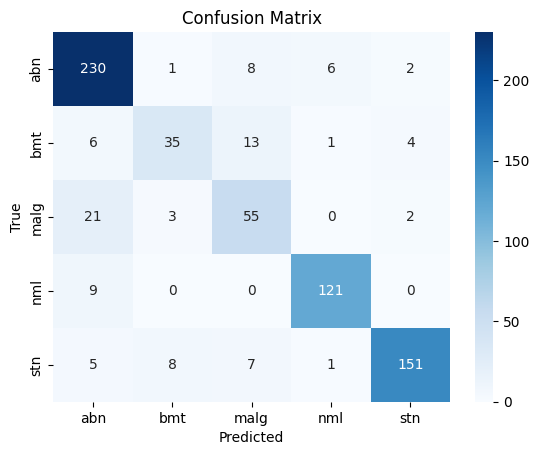

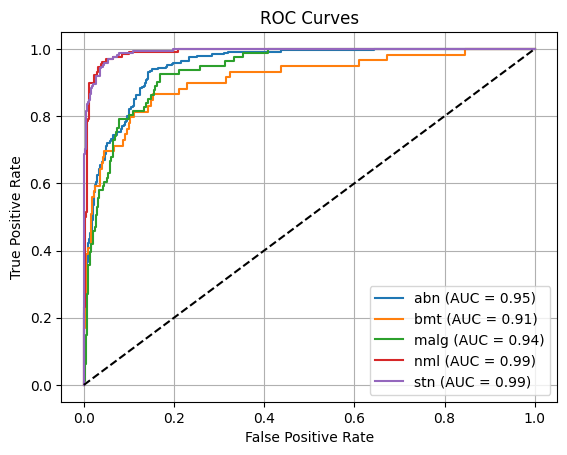

In [12]:
print("\n--- Training ResNet18 ---")
resnet_model = get_model("resnet18", num_classes=len(class_names))
trained_resnet_model, _, _, _, val_acc_resnet = train_model(resnet_model, epochs=30, patience=5) # Capture val_acc
evaluate_model(trained_resnet_model) # Evaluate individual model
plot_roc(trained_resnet_model) # Plot ROC for individual model
model_results["ResNet18"] = np.max(val_acc_resnet) # Store max val acc from training
all_trained_models.append(trained_resnet_model)

### Efficientnet_B0


--- Training EfficientNetB0 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


Epoch 1: Train Acc=0.58, Val Acc=0.75, LR=0.000100
Epoch 2: Train Acc=0.75, Val Acc=0.80, LR=0.000100
Epoch 3: Train Acc=0.78, Val Acc=0.82, LR=0.000100
Epoch 4: Train Acc=0.83, Val Acc=0.82, LR=0.000100
Epoch 5: Train Acc=0.84, Val Acc=0.83, LR=0.000100
Epoch 6: Train Acc=0.85, Val Acc=0.82, LR=0.000100
Epoch 7: Train Acc=0.88, Val Acc=0.83, LR=0.000100
Epoch 8: Train Acc=0.88, Val Acc=0.84, LR=0.000100
Epoch 9: Train Acc=0.89, Val Acc=0.83, LR=0.000100
Epoch 10: Train Acc=0.91, Val Acc=0.84, LR=0.000100
Epoch 11: Train Acc=0.92, Val Acc=0.83, LR=0.000100
Epoch 12: Train Acc=0.93, Val Acc=0.86, LR=0.000100
Epoch 13: Train Acc=0.91, Val Acc=0.82, LR=0.000100
Epoch 14: Train Acc=0.94, Val Acc=0.82, LR=0.000100
Epoch 15: Train Acc=0.93, Val Acc=0.83, LR=0.000100
Epoch 16: Train Acc=0.94, Val Acc=0.83, LR=0.000100
Epoch 17: Train Acc=0.95, Val Acc=0.84, LR=0.000100
Early stopping triggered after 17 epochs. Validation accuracy did not improve for 5 epochs.
              precision    recall

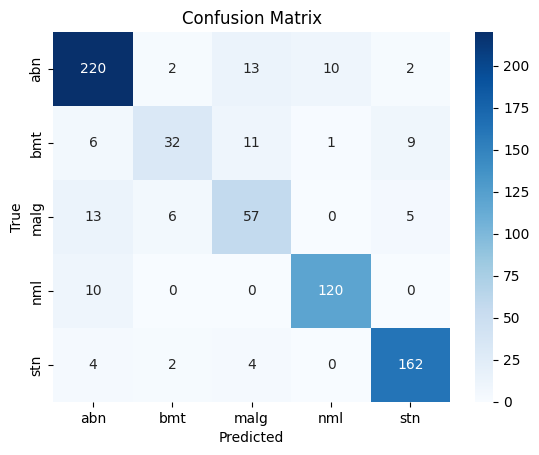

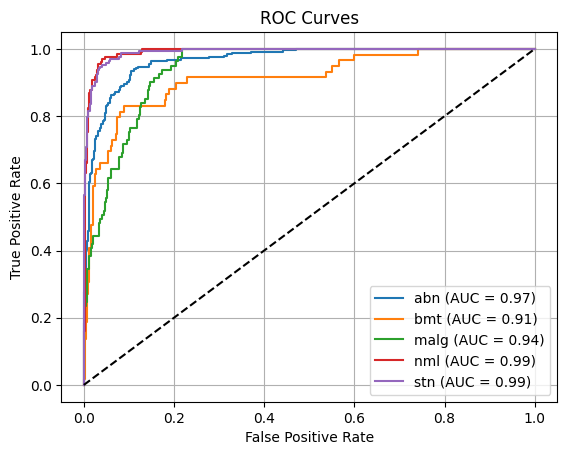

In [13]:
print("\n--- Training EfficientNetB0 ---")
efficientnet_model = get_model("efficientnet_b0", num_classes=len(class_names))
trained_efficientnet_model, _, _, _, val_acc_efficientnet = train_model(efficientnet_model, epochs=30, patience=5)
evaluate_model(trained_efficientnet_model)
plot_roc(trained_efficientnet_model)
model_results["EfficientNetB0"] = np.max(val_acc_efficientnet)
all_trained_models.append(trained_efficientnet_model)

### Densenet-121


--- Training DenseNet121 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


Epoch 1: Train Acc=0.67, Val Acc=0.74, LR=0.000100
Epoch 2: Train Acc=0.79, Val Acc=0.81, LR=0.000100
Epoch 3: Train Acc=0.83, Val Acc=0.81, LR=0.000100
Epoch 4: Train Acc=0.86, Val Acc=0.81, LR=0.000100
Epoch 5: Train Acc=0.87, Val Acc=0.85, LR=0.000100
Epoch 6: Train Acc=0.90, Val Acc=0.84, LR=0.000100
Epoch 7: Train Acc=0.90, Val Acc=0.83, LR=0.000100
Epoch 8: Train Acc=0.92, Val Acc=0.85, LR=0.000100
Epoch 9: Train Acc=0.92, Val Acc=0.83, LR=0.000100
Epoch 10: Train Acc=0.93, Val Acc=0.83, LR=0.000100
Epoch 11: Train Acc=0.95, Val Acc=0.85, LR=0.000100
Epoch 12: Train Acc=0.93, Val Acc=0.84, LR=0.000100
Epoch 13: Train Acc=0.95, Val Acc=0.84, LR=0.000100
Early stopping triggered after 13 epochs. Validation accuracy did not improve for 5 epochs.
              precision    recall  f1-score   support

         abn       0.85      0.92      0.88       247
         bmt       0.73      0.68      0.70        59
        malg       0.76      0.56      0.64        81
         nml       0.92 

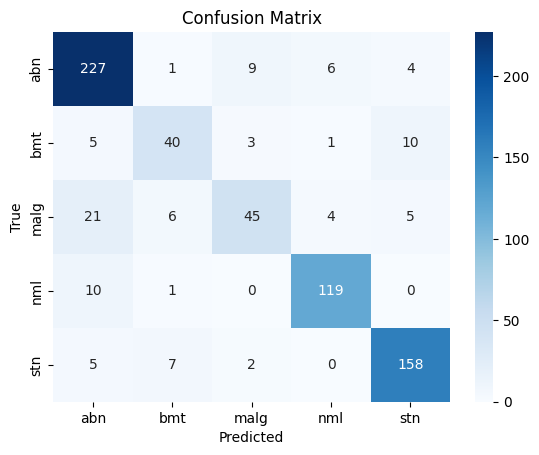

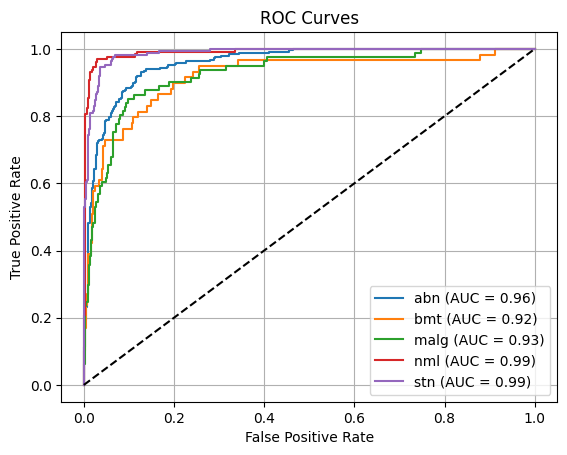

In [14]:
print("\n--- Training DenseNet121 ---")
densenet_model = get_model("densenet121", num_classes=len(class_names))
trained_densenet_model, _, _, _, val_acc_densenet = train_model(densenet_model, epochs=30, patience=5)
evaluate_model(trained_densenet_model)
plot_roc(trained_densenet_model)
model_results["DenseNet121"] = np.max(val_acc_densenet)
all_trained_models.append(trained_densenet_model)

### MobileNetV2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



--- Training MobileNetV2 ---


100%|██████████| 13.6M/13.6M [00:00<00:00, 67.8MB/s]


Epoch 1: Train Acc=0.64, Val Acc=0.65, LR=0.000100
Epoch 2: Train Acc=0.76, Val Acc=0.80, LR=0.000100
Epoch 3: Train Acc=0.81, Val Acc=0.81, LR=0.000100
Epoch 4: Train Acc=0.83, Val Acc=0.81, LR=0.000100
Epoch 5: Train Acc=0.84, Val Acc=0.82, LR=0.000100
Epoch 6: Train Acc=0.87, Val Acc=0.82, LR=0.000100
Epoch 7: Train Acc=0.89, Val Acc=0.82, LR=0.000100
Epoch 8: Train Acc=0.90, Val Acc=0.83, LR=0.000100
Epoch 9: Train Acc=0.89, Val Acc=0.83, LR=0.000100
Epoch 10: Train Acc=0.91, Val Acc=0.83, LR=0.000100
Epoch 11: Train Acc=0.92, Val Acc=0.82, LR=0.000100
Epoch 12: Train Acc=0.90, Val Acc=0.82, LR=0.000100
Epoch 13: Train Acc=0.91, Val Acc=0.85, LR=0.000100
Epoch 14: Train Acc=0.94, Val Acc=0.83, LR=0.000100
Epoch 15: Train Acc=0.95, Val Acc=0.82, LR=0.000100
Epoch 16: Train Acc=0.94, Val Acc=0.83, LR=0.000100
Epoch 17: Train Acc=0.93, Val Acc=0.84, LR=0.000100
Epoch 18: Train Acc=0.95, Val Acc=0.83, LR=0.000100
Early stopping triggered after 18 epochs. Validation accuracy did not imp

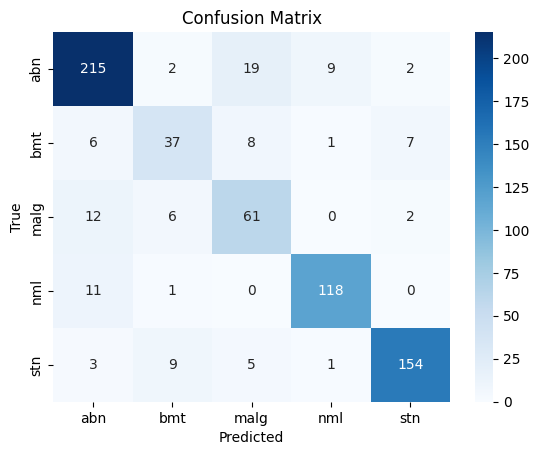

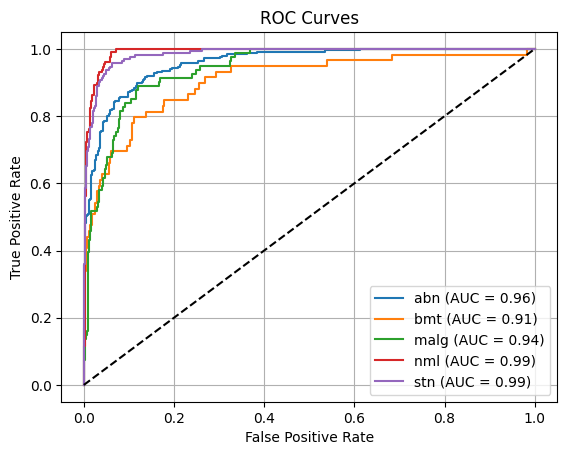

In [15]:
print("\n--- Training MobileNetV2 ---")
mobilenet_model = get_model("mobilenet_v2", num_classes=len(class_names))
trained_mobilenet_model, _, _, _, val_acc_mobilenet = train_model(mobilenet_model, epochs=30, patience=5)
evaluate_model(trained_mobilenet_model)
plot_roc(trained_mobilenet_model)
model_results["MobileNetV2"] = np.max(val_acc_mobilenet)
all_trained_models.append(trained_mobilenet_model)

### ShuffleNetV2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth



--- Training ShuffleNetV2 ---


100%|██████████| 8.79M/8.79M [00:00<00:00, 99.8MB/s]


Epoch 1: Train Acc=0.54, Val Acc=0.57, LR=0.000100
Epoch 2: Train Acc=0.60, Val Acc=0.67, LR=0.000100
Epoch 3: Train Acc=0.66, Val Acc=0.70, LR=0.000100
Epoch 4: Train Acc=0.70, Val Acc=0.72, LR=0.000100
Epoch 5: Train Acc=0.70, Val Acc=0.73, LR=0.000100
Epoch 6: Train Acc=0.73, Val Acc=0.77, LR=0.000100
Epoch 7: Train Acc=0.77, Val Acc=0.79, LR=0.000100
Epoch 8: Train Acc=0.81, Val Acc=0.82, LR=0.000100
Epoch 9: Train Acc=0.82, Val Acc=0.83, LR=0.000100
Epoch 10: Train Acc=0.84, Val Acc=0.83, LR=0.000100
Epoch 11: Train Acc=0.86, Val Acc=0.83, LR=0.000100
Epoch 12: Train Acc=0.86, Val Acc=0.83, LR=0.000100
Epoch 13: Train Acc=0.87, Val Acc=0.82, LR=0.000100
Epoch 14: Train Acc=0.87, Val Acc=0.83, LR=0.000100
Epoch 15: Train Acc=0.89, Val Acc=0.83, LR=0.000100
Epoch 16: Train Acc=0.89, Val Acc=0.84, LR=0.000100
Epoch 17: Train Acc=0.90, Val Acc=0.83, LR=0.000100
Epoch 18: Train Acc=0.89, Val Acc=0.82, LR=0.000100
Epoch 19: Train Acc=0.89, Val Acc=0.86, LR=0.000100
Epoch 20: Train Acc=0

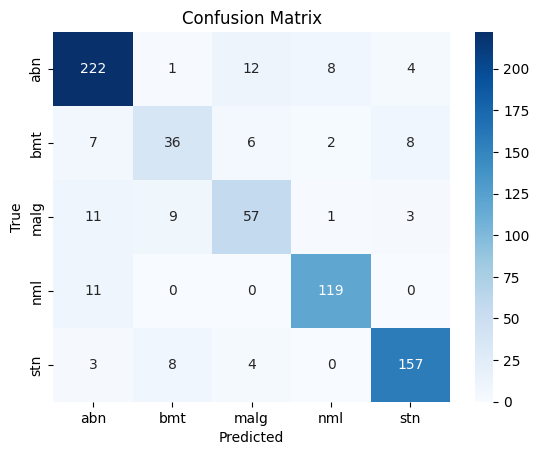

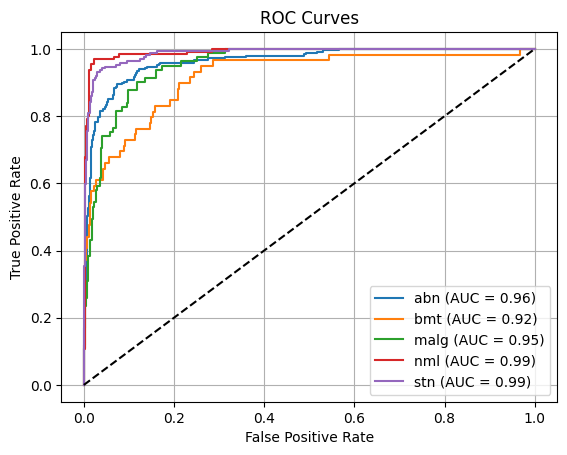

In [16]:
print("\n--- Training ShuffleNetV2 ---")
shufflenet_model = get_model("shufflenet_v2", num_classes=len(class_names))
trained_shufflenet_model, _, _, _, val_acc_shufflenet = train_model(shufflenet_model, epochs=30, patience=5)
evaluate_model(trained_shufflenet_model)
plot_roc(trained_shufflenet_model)
model_results["ShuffleNetV2"] = np.max(val_acc_shufflenet)
all_trained_models.append(trained_shufflenet_model)

### SqueezeNet1_0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth



--- Training SqueezeNet ---


100%|██████████| 4.78M/4.78M [00:00<00:00, 69.2MB/s]


Epoch 1: Train Acc=0.57, Val Acc=0.71, LR=0.000100
Epoch 2: Train Acc=0.69, Val Acc=0.71, LR=0.000100
Epoch 3: Train Acc=0.70, Val Acc=0.73, LR=0.000100
Epoch 4: Train Acc=0.72, Val Acc=0.65, LR=0.000100
Epoch 5: Train Acc=0.76, Val Acc=0.77, LR=0.000100
Epoch 6: Train Acc=0.76, Val Acc=0.79, LR=0.000100
Epoch 7: Train Acc=0.78, Val Acc=0.79, LR=0.000100
Epoch 8: Train Acc=0.79, Val Acc=0.75, LR=0.000100
Epoch 9: Train Acc=0.79, Val Acc=0.79, LR=0.000100
Epoch 10: Train Acc=0.79, Val Acc=0.80, LR=0.000100
Epoch 11: Train Acc=0.80, Val Acc=0.76, LR=0.000100
Epoch 12: Train Acc=0.80, Val Acc=0.80, LR=0.000100
Epoch 13: Train Acc=0.81, Val Acc=0.80, LR=0.000100
Epoch 14: Train Acc=0.83, Val Acc=0.78, LR=0.000100
Epoch 15: Train Acc=0.83, Val Acc=0.82, LR=0.000100
Epoch 16: Train Acc=0.83, Val Acc=0.83, LR=0.000100
Epoch 17: Train Acc=0.83, Val Acc=0.80, LR=0.000100
Epoch 18: Train Acc=0.83, Val Acc=0.79, LR=0.000100
Epoch 19: Train Acc=0.84, Val Acc=0.83, LR=0.000100
Epoch 20: Train Acc=0

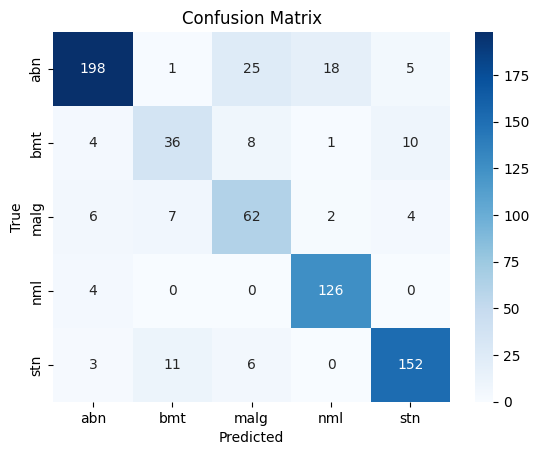

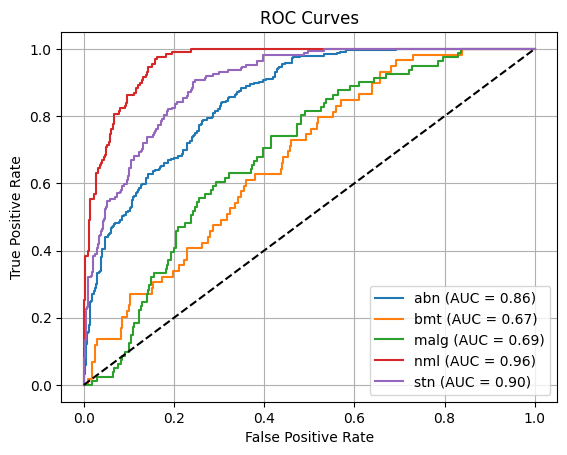

In [17]:
print("\n--- Training SqueezeNet ---")
squeezenet_model = get_model("squeezenet", num_classes=len(class_names))
trained_squeezenet_model, _, _, _, val_acc_squeezenet = train_model(squeezenet_model, epochs=30, patience=5)
evaluate_model(trained_squeezenet_model)
plot_roc(trained_squeezenet_model)
model_results["squeezeNet"] = np.max(val_acc_squeezenet)
all_trained_models.append(trained_squeezenet_model)


### Ensemble Evaluation


--- Evaluating Ensemble Model ---

--- Ensemble Model Performance ---
              precision    recall  f1-score   support

         abn       0.88      0.92      0.90       247
         bmt       0.77      0.68      0.72        59
        malg       0.71      0.68      0.70        81
         nml       0.96      0.95      0.95       130
         stn       0.92      0.93      0.93       172

    accuracy                           0.88       689
   macro avg       0.85      0.83      0.84       689
weighted avg       0.88      0.88      0.88       689



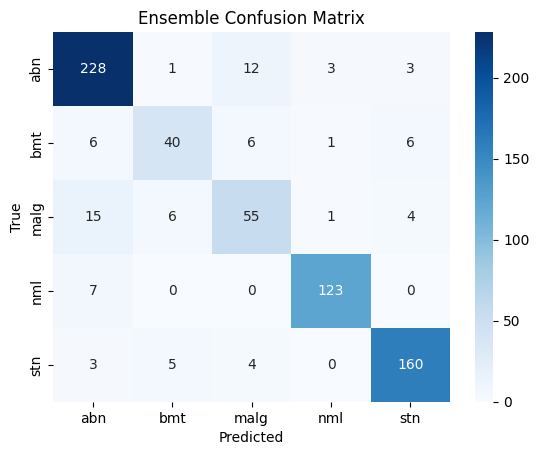

In [18]:
print("\n--- Evaluating Ensemble Model ---")
ensemble_accuracy, ensemble_probs, y_true_ensemble = ensemble_evaluate(all_trained_models, val_loader, class_names, device)

### Plot ROC for Ensemble

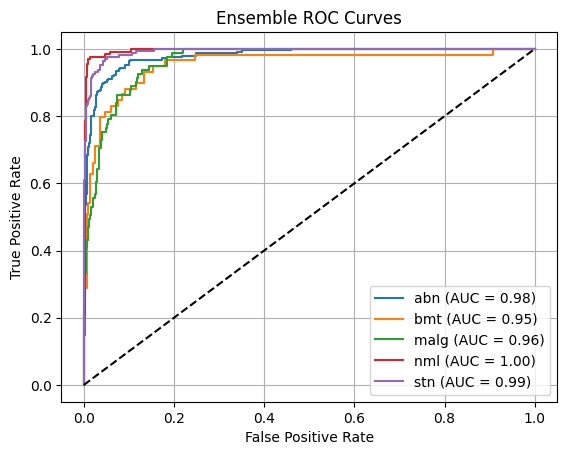

In [19]:
plt.figure()
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(label_binarize(y_true_ensemble, classes=list(range(len(class_names))) )[:, i], ensemble_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

model_results["Ensemble"] = ensemble_accuracy # Store ensemble accuracy

### Table

In [20]:
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Validation Accuracy"])
results_df["Validation Accuracy"] = results_df["Validation Accuracy"].apply(lambda x: f"{x*100:.2f}%")

print("\nModel Performance Summary (Including Ensemble):")
print(results_df.to_string(index=False))


Model Performance Summary (Including Ensemble):
         Model Validation Accuracy
      ResNet18              85.92%
EfficientNetB0              85.78%
   DenseNet121              85.49%
   MobileNetV2              84.91%
  ShuffleNetV2              85.78%
    squeezeNet              83.31%
      Ensemble              87.95%
